# **Environment Setup**

*Note that summaries and insights will be omitted from this file since the results are very similar to the first half of the year's analysis.*

In [1]:
%pip install --upgrade pandas pyarrow scikit-learn statsmodels matplotlib dask

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, time
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import dask.dataframe as dd
import os

Note: you may need to restart the kernel to use updated packages.


# **Data Acquisition**

In [2]:
# Load NYC Taxi Trip Data for a single month to show the data details
taxi_data_path = 'fhvhv_tripdata_2020-01.parquet'
df = pd.read_parquet(taxi_data_path)
print("Taxi data shape:", df.shape)
df.head()

Taxi data shape: (20569368, 24)


,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B02864,B02864,2020-01-01 00:40:13,2020-01-01 00:43:34,2020-01-01 00:45:34,2020-01-01 01:02:20,148,90,1.93,...,2.70,2.75,NaN,0.0,18.25,N,N,,N,N
1,HV0003,B02682,B02682,2020-01-01 00:42:31,2020-01-01 00:46:33,2020-01-01 00:47:50,2020-01-01 00:53:23,114,79,0.81,...,1.31,2.75,NaN,0.0,10.84,N,N,,N,N
2,HV0003,B02764,B02764,2020-01-01 00:01:42,2020-01-01 00:02:06,2020-01-01 00:04:37,2020-01-01 00:21:49,4,125,2.53,...,1.39,2.75,NaN,3.0,11.73,N,N,,N,N
3,HV0003,B02764,B02764,2020-01-01 00:21:23,2020-01-01 00:26:02,2020-01-01 00:26:36,2020-01-01 00:33:00,231,113,1.11,...,0.75,2.75,NaN,0.0,5.84,N,N,,N,N
4,HV0003,B02764,B02764,2020-01-01 00:32:20,2020-01-01 00:37:06,2020-01-01 00:37:49,2020-01-01 00:46:59,114,144,1.10,...,1.03,2.75,NaN,0.0,7.69,N,N,,N,N


In [3]:
# Loading the combined data for first 6 month of 2020
folder_path = './2020/next_half/'

# Read all Parquet files in the folder.
taxi_cols = ['pickup_datetime', 'dropoff_datetime', 'PULocationID']
ddf = dd.read_parquet(os.path.join(folder_path, '*.parquet'), engine='pyarrow', columns=taxi_cols)

# To work with a pandas DataFrame in memory we can call .compute().
df = ddf.sample(frac=0.1, random_state=42).compute()

# Verify by checking the shape and a few rows.
print("Combined dataframe shape:", df.shape)
df.head()

Combined dataframe shape: (6966438, 3)


,pickup_datetime,dropoff_datetime,PULocationID
9725603,2020-07-31 12:20:05,2020-07-31 12:38:38,97
27379007,2020-09-17 14:56:31,2020-09-17 15:21:16,113
3311960,2020-07-12 00:37:37,2020-07-12 00:41:44,19
22556621,2020-09-04 23:43:00,2020-09-04 23:51:12,68
25667988,2020-09-12 21:53:07,2020-09-12 22:25:37,228


In [4]:
# Load Taxi Zone Lookup Data from the uploaded file
zone_lookup_path = 'taxi+_zone_lookup.csv'
zones = pd.read_csv(zone_lookup_path)
print("Zone lookup shape:", zones.shape)
zones.head()

Zone lookup shape: (265, 4)


,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [5]:
# Load NYC Weather Data
weather_data_path = 'NYC_Weather_2016_2022.csv'
weather = pd.read_csv(weather_data_path)
print("Weather data shape:", weather.shape)
weather.head()

Weather data shape: (59760, 10)


,time,temperature_2m (°C),precipitation (mm),rain (mm),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),windspeed_10m (km/h),winddirection_10m (°)
0,2016-01-01T00:00,7.6,0.0,0.0,69.0,53.0,0.0,72.0,10.0,296.0
1,2016-01-01T01:00,7.5,0.0,0.0,20.0,4.0,0.0,56.0,9.8,287.0
2,2016-01-01T02:00,7.1,0.0,0.0,32.0,3.0,0.0,99.0,9.7,285.0
3,2016-01-01T03:00,6.6,0.0,0.0,35.0,5.0,0.0,100.0,9.2,281.0
4,2016-01-01T04:00,6.3,0.0,0.0,34.0,4.0,0.0,100.0,9.1,279.0


# **Data Cleaning & Preprocessing**

### Taxi Data Cleaning

In [6]:
# Convert the date columns to datetime objects
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

# Compute trip duration in minutes
df['trip_duration_min'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60

# Filter out trips with non-positive durations and extreme outliers (> 180 minutes)
df = df[(df['trip_duration_min'] > 0) & (df['trip_duration_min'] <= 180)]
print("Taxi data shape after cleaning durations:", df.shape)

# Remove duplicates and report missing values
df.drop_duplicates(inplace=True)
print("Missing values in taxi data:\n", df.isnull().sum())

Taxi data shape after cleaning durations: (6965361, 4)
Missing values in taxi data:
 pickup_datetime      0
dropoff_datetime     0
PULocationID         0
trip_duration_min    0
dtype: int64


### Merge Taxi Data with Zone Lookup to Get Boroughs

In [7]:
# Assuming 'PULocationID' is the key in taxi data and 'LocationID' in the zones file
df = df.merge(zones[['LocationID', 'Borough']], how='left', left_on='PULocationID', right_on='LocationID')
print("Data shape after merging with zones:", df.shape)
df[['PULocationID', 'Borough']].head()

Data shape after merging with zones: (6965275, 6)


,PULocationID,Borough
0,97,Brooklyn
1,113,Manhattan
2,19,Queens
3,68,Manhattan
4,228,Brooklyn


### Weather Data Preparation & Integration

In [8]:
# Convert the 'time' column in weather data to datetime
weather['time'] = pd.to_datetime(weather['time'])

# Create an hourly timestamp from pickup_datetime in taxi data to match weather resolution
df['pickup_hour'] = df['pickup_datetime'].dt.floor('H')

# Merge weather data with taxi data on the hourly timestamp
df = df.merge(weather, how='left', left_on='pickup_hour', right_on='time')
print("Data shape after merging with weather:", df.shape)
df[['pickup_datetime', 'pickup_hour', 'time', 'temperature_2m (°C)', 'precipitation (mm)']].head()

C:\Users\dell\AppData\Local\Temp\ipykernel_20164\1205313015.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['pickup_hour'] = df['pickup_datetime'].dt.floor('H')


Data shape after merging with weather: (6965275, 17)


,pickup_datetime,pickup_hour,time,temperature_2m (°C),precipitation (mm)
0,2020-07-31 12:20:05,2020-07-31 12:00:00,2020-07-31 12:00:00,22.5,0.7
1,2020-09-17 14:56:31,2020-09-17 14:00:00,2020-09-17 14:00:00,18.7,0.0
2,2020-07-12 00:37:37,2020-07-12 00:00:00,2020-07-12 00:00:00,26.3,0.0
3,2020-09-04 23:43:00,2020-09-04 23:00:00,2020-09-04 23:00:00,27.1,0.0
4,2020-09-12 21:53:07,2020-09-12 21:00:00,2020-09-12 21:00:00,21.0,0.0


# **Feature Engineering**

In [9]:
# Define Departure Periods based on pickup time.
def assign_period(dt):
    """Assign a time period based on the pickup time."""
    pickup_time = dt.time()
    if time(6, 0) <= pickup_time < time(10, 0):
        return 'morning_peak'
    elif time(15, 0) <= pickup_time < time(19, 0):
        return 'afternoon_peak'
    elif time(19, 0) <= pickup_time < time(23, 0):
        return 'evening_peak'
    else:
        return 'off_peak'

df['departure_period'] = df['pickup_datetime'].apply(assign_period)
print("Departure period counts:")
print(df['departure_period'].value_counts())

# Extract day-of-week from pickup_datetime
df['pickup_dayofweek'] = df['pickup_datetime'].dt.day_name()

Departure period counts:
departure_period
off_peak          2753845
afternoon_peak    1672836
evening_peak      1477221
morning_peak      1061373
Name: count, dtype: int64


# **Exploratory Data Analysis**

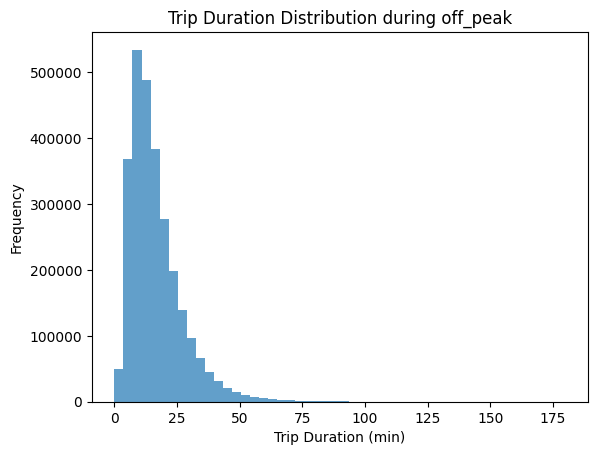

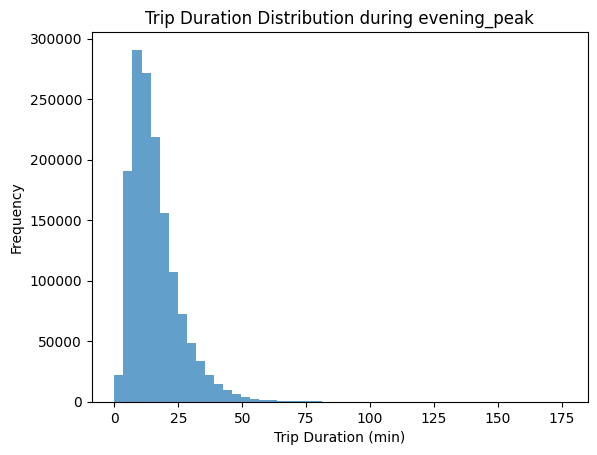

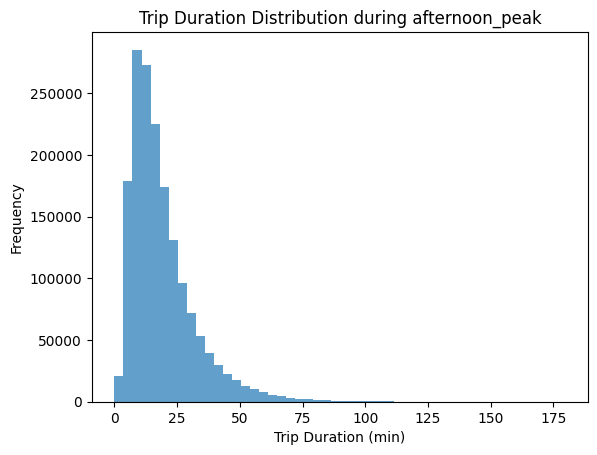

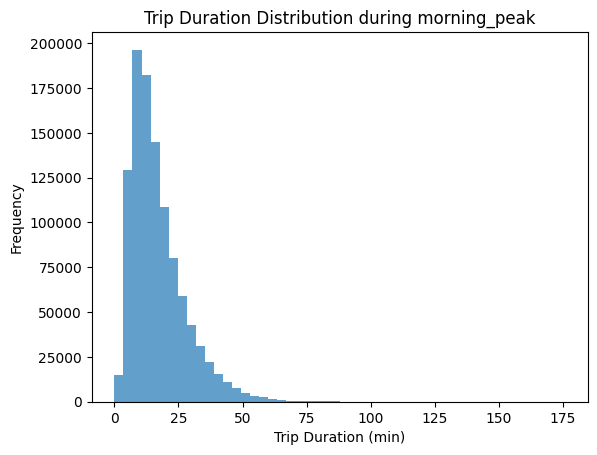

In [10]:
# Histogram of Trip Durations for each Departure Period
periods = df['departure_period'].unique()
for period in periods:
    subset = df[df['departure_period'] == period]
    plt.figure()
    plt.hist(subset['trip_duration_min'], bins=50, alpha=0.7)
    plt.title(f'Trip Duration Distribution during {period}')
    plt.xlabel('Trip Duration (min)')
    plt.ylabel('Frequency')
    plt.show()

The histograms above demonstrates that the bulk of taxi trips are of short duration with a long right tail. This pattern is typical in urban taxi datasets and underscores the importance of handling extreme values during model development.

<Figure size 1000x600 with 0 Axes>

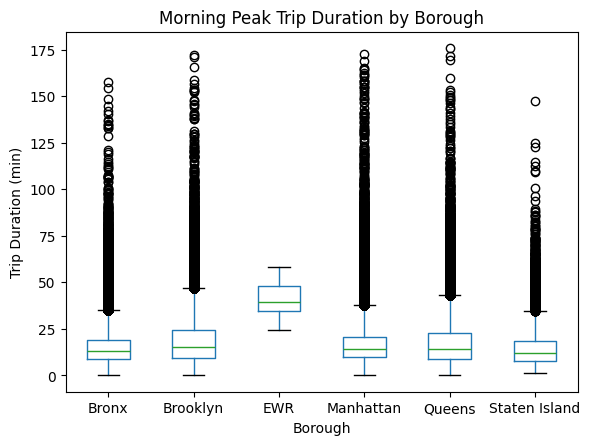

In [11]:
# Boxplot of Trip Duration by Borough for a selected period (e.g., morning_peak)
subset = df[df['departure_period'] == 'morning_peak']
plt.figure(figsize=(10, 6))
subset.boxplot(column='trip_duration_min', by='Borough', grid=False)
plt.title('Morning Peak Trip Duration by Borough')
plt.suptitle('')
plt.xlabel('Borough')
plt.ylabel('Trip Duration (min)')
plt.show()

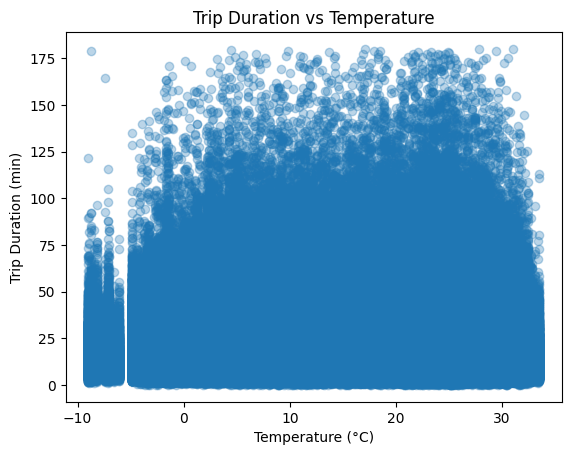

In [12]:
# Scatter Plot: Trip Duration vs Temperature
plt.figure()
plt.scatter(df['temperature_2m (°C)'], df['trip_duration_min'], alpha=0.3)
plt.title('Trip Duration vs Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Trip Duration (min)')
plt.show()

C:\Users\dell\AppData\Local\Temp\ipykernel_20164\1350851383.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(period_data, labels=period_labels)


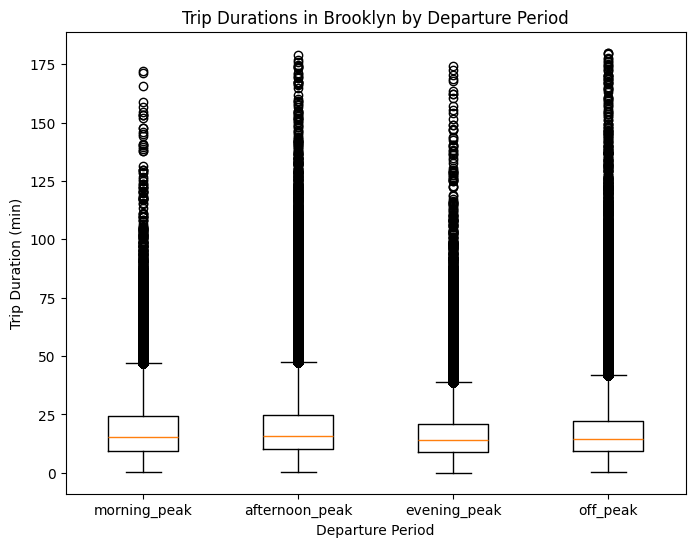

C:\Users\dell\AppData\Local\Temp\ipykernel_20164\1350851383.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(period_data, labels=period_labels)


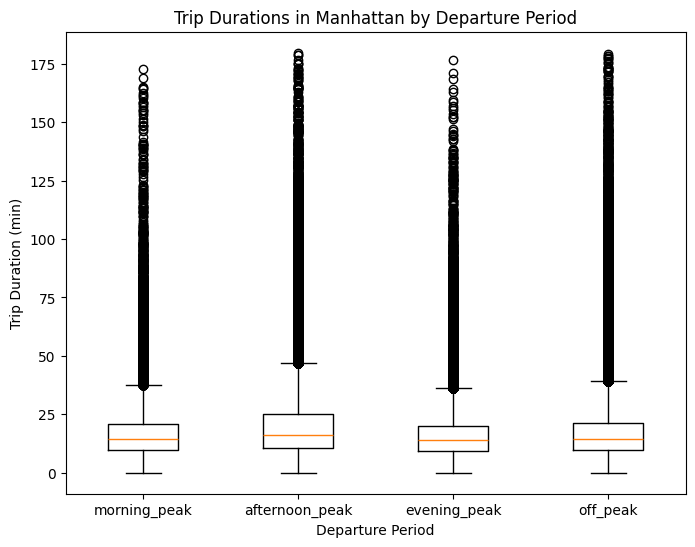

C:\Users\dell\AppData\Local\Temp\ipykernel_20164\1350851383.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(period_data, labels=period_labels)


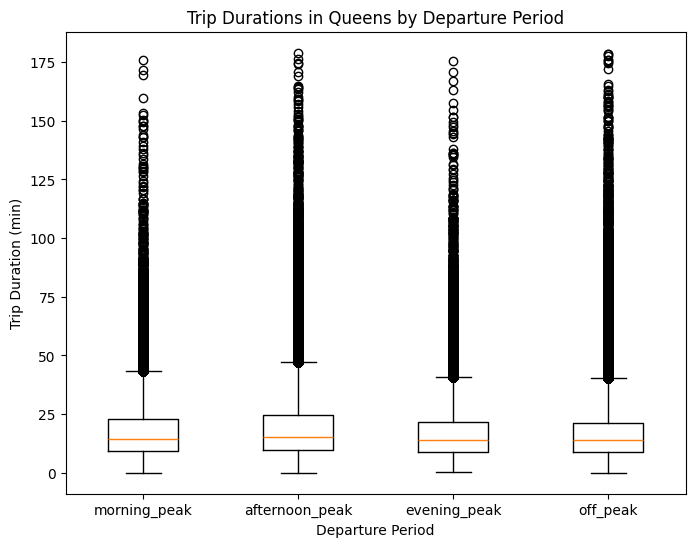

C:\Users\dell\AppData\Local\Temp\ipykernel_20164\1350851383.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(period_data, labels=period_labels)


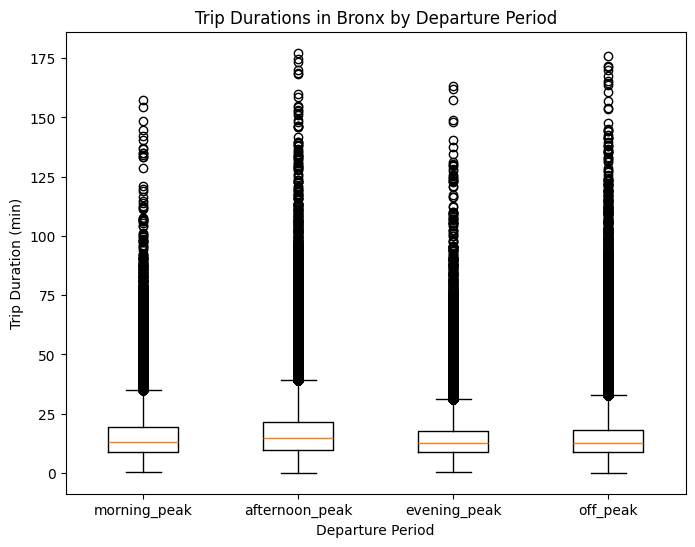

C:\Users\dell\AppData\Local\Temp\ipykernel_20164\1350851383.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(period_data, labels=period_labels)


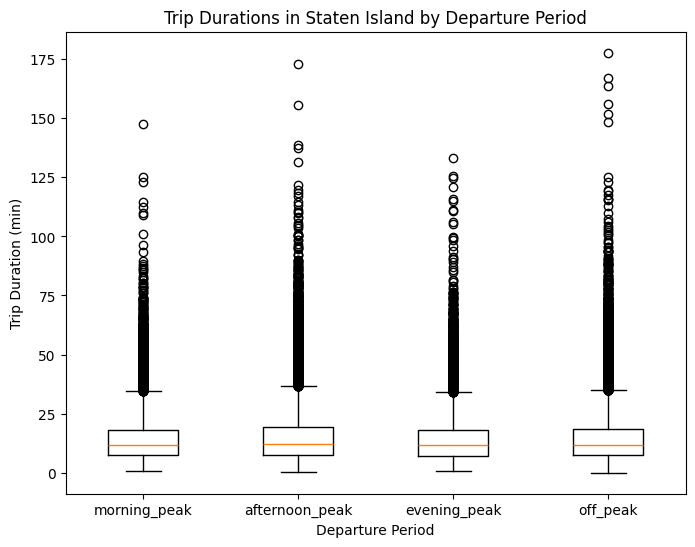

C:\Users\dell\AppData\Local\Temp\ipykernel_20164\1350851383.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(period_data, labels=period_labels)


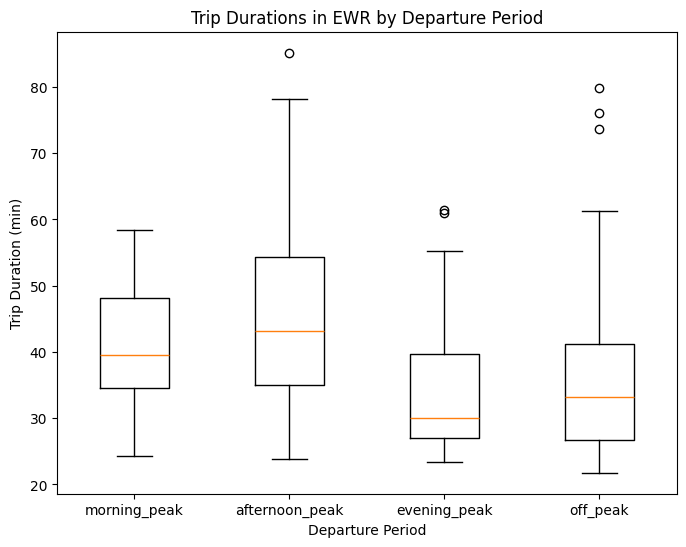

In [13]:
# Grouped Boxplots by Borough and Departure Period
# We loop over each borough and plot trip duration distribution by departure period.
boroughs = df['Borough'].dropna().unique()

for borough in boroughs:
    subset = df[df['Borough'] == borough]
    plt.figure(figsize=(8, 6))
    # Create a list to collect trip duration for each period
    period_data = []
    period_labels = []
    for period in ['morning_peak', 'afternoon_peak', 'evening_peak', 'off_peak']:
        data = subset[subset['departure_period'] == period]['trip_duration_min']
        if not data.empty:
            period_data.append(data)
            period_labels.append(period)
    if period_data:
        plt.boxplot(period_data, labels=period_labels)
        plt.title(f'Trip Durations in {borough} by Departure Period')
        plt.xlabel('Departure Period')
        plt.ylabel('Trip Duration (min)')
        plt.show()

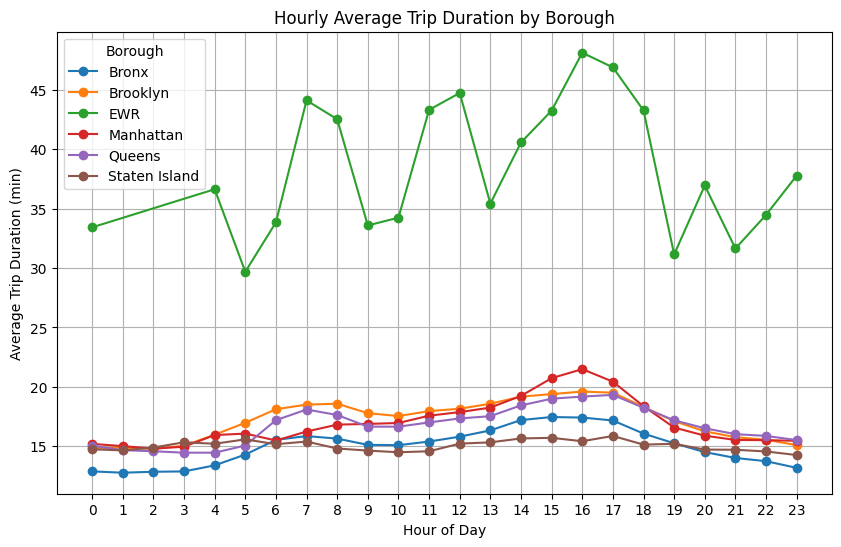

In [14]:
# Hourly Average Trip Duration by Borough
# First, extract the hour from the pickup_datetime.
df['pickup_hour_only'] = df['pickup_datetime'].dt.hour

# Group by borough and the pickup hour, then compute the average trip duration.
avg_duration = df.groupby(['Borough', 'pickup_hour_only'])['trip_duration_min'].mean().reset_index()

# Plot a separate line for each borough.
boroughs = avg_duration['Borough'].unique()
plt.figure(figsize=(10, 6))
for borough in boroughs:
    borough_data = avg_duration[avg_duration['Borough'] == borough]
    plt.plot(borough_data['pickup_hour_only'], borough_data['trip_duration_min'], marker='o', label=borough)

plt.title('Hourly Average Trip Duration by Borough')
plt.xlabel('Hour of Day')
plt.ylabel('Average Trip Duration (min)')
plt.legend(title='Borough')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()


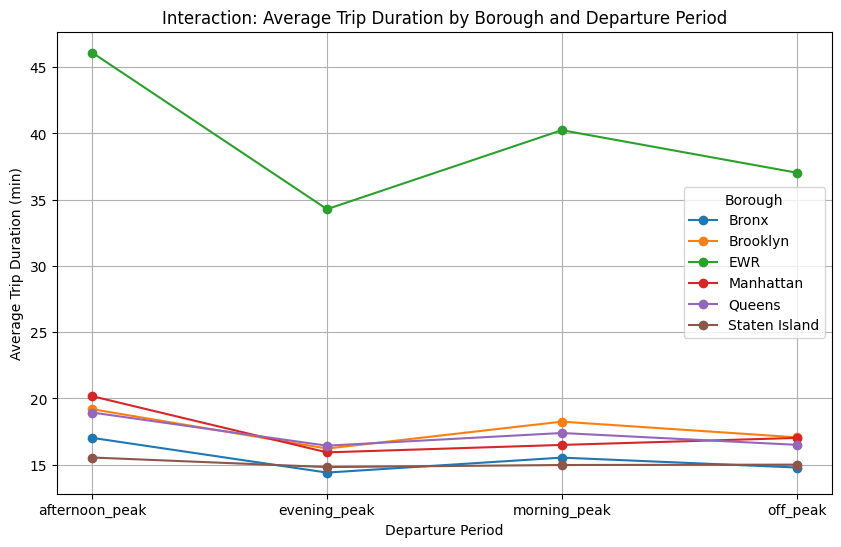

In [15]:
# Interaction Plot for Average Trip Duration
# Group the data by Borough and departure_period and compute the mean.
interaction_df = df.groupby(['Borough', 'departure_period'])['trip_duration_min'].mean().reset_index()

# Create a separate line plot for each borough.
boroughs = interaction_df['Borough'].unique()
plt.figure(figsize=(10, 6))
for borough in boroughs:
    borough_data = interaction_df[interaction_df['Borough'] == borough]
    plt.plot(borough_data['departure_period'], borough_data['trip_duration_min'], marker='o', label=borough)

plt.title('Interaction: Average Trip Duration by Borough and Departure Period')
plt.xlabel('Departure Period')
plt.ylabel('Average Trip Duration (min)')
plt.legend(title='Borough')
plt.grid(True)
plt.show()

### Additional error metric (MAE) and build an interactive heatmap

In [16]:
# Install plotly and nbformat if not already installed
%pip install plotly nbformat

import plotly.express as px

df['pickup_hour'] = df['pickup_datetime'].dt.hour

# Create a pivot table to get the average trip duration by hour and Borough.
pivot_table = df.groupby(['pickup_hour', 'Borough'])['trip_duration_min'].mean().reset_index()
pivot = pivot_table.pivot(index='pickup_hour', columns='Borough', values='trip_duration_min')

# Generate an interactive heatmap
fig = px.imshow(
    pivot,
    labels=dict(x="Borough", y="Hour of Day", color="Avg Trip Duration (min)"),
    x=pivot.columns,
    y=pivot.index,
    aspect="auto",
    title="Heatmap: Average Trip Duration by Hour and Borough"
)
fig.show()

Note: you may need to restart the kernel to use updated packages.


# **Regression Model Training**

In [17]:
# Prepare the Data for Regression
# Focus on the peak periods or use the entire dataset as needed
peak_periods = ['morning_peak', 'afternoon_peak', 'evening_peak']
df_model = df[df['departure_period'].isin(peak_periods)].copy()

# One-hot encode categorical variables: departure_period, Borough, and optional pickup_dayofweek
df_model_encoded = pd.get_dummies(df_model, columns=['departure_period', 'Borough', 'pickup_dayofweek'], drop_first=True)

# Choose features for the model.
# Drop columns that are not needed (e.g., original datetime fields and keys)
drop_cols = ['trip_duration_min', 'pickup_datetime', 'dropoff_datetime', 'LocationID', 'pickup_hour', 'time']
X = df_model_encoded.drop(columns=drop_cols)
y = df_model_encoded['trip_duration_min']

print("Encoded features preview:")
print(X.head())

Encoded features preview:
   PULocationID  temperature_2m (°C)  precipitation (mm)  rain (mm)  \
4           228                 21.0                 0.0        0.0   
5           250                 28.8                 0.0        0.0   
6            71                 24.6                 0.0        0.0   
8           140                 21.9                 0.0        0.0   
9           137                 21.9                 0.0        0.0   

   cloudcover (%)  cloudcover_low (%)  cloudcover_mid (%)  \
4            48.0                42.0                 0.0   
5            34.0                 9.0                 6.0   
6            38.0                21.0                 0.0   
8             0.0                 0.0                 0.0   
9            55.0                 0.0                44.0   

   cloudcover_high (%)  windspeed_10m (km/h)  winddirection_10m (°)  ...  \
4                 35.0                  14.0                  102.0  ...   
5                 74.0      

In [18]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Handle missing values in the dataset
# Drop rows with missing values in X_train and X_test
X_train_clean = X_train.dropna()
X_test_clean = X_test.dropna()

# Ensure corresponding rows in y_train and y_test are also dropped
y_train_clean = y_train[X_train_clean.index]
y_test_clean = y_test[X_test_clean.index]

# Train a Linear Regression Model using scikit-learn
lr = LinearRegression()
lr.fit(X_train_clean, y_train_clean)
y_pred = lr.predict(X_test_clean)
rmse = np.sqrt(mean_squared_error(y_test_clean, y_pred))
print("Linear Regression RMSE:", rmse)

Linear Regression RMSE: 11.4738612569684


In [20]:
# Detailed Regression Analysis using statsmodels
# Add a constant term to the training set
X_train_sm = sm.add_constant(X_train)

# Ensure all data in X_train_sm is numeric
X_train_sm = X_train_sm.astype(float)

# Also ensure y_train is numeric if it's not already
y_train_numeric = y_train.astype(float)

# Remove rows with NaN or infinite values from X_train_sm and y_train_numeric
X_train_sm_clean = X_train_sm.replace([np.inf, -np.inf], np.nan).dropna()
y_train_numeric_clean = y_train_numeric[X_train_sm_clean.index]

# Fit the OLS model using statsmodels
model_sm = sm.OLS(y_train_numeric_clean, X_train_sm_clean).fit()

# Print the summary
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:      trip_duration_min   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     3607.
Date:                Sun, 13 Apr 2025   Prob (F-statistic):               0.00
Time:                        03:07:05   Log-Likelihood:            -1.3010e+07
No. Observations:             3369144   AIC:                         2.602e+07
Df Residuals:                 3369119   BIC:                         2.602e+07
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

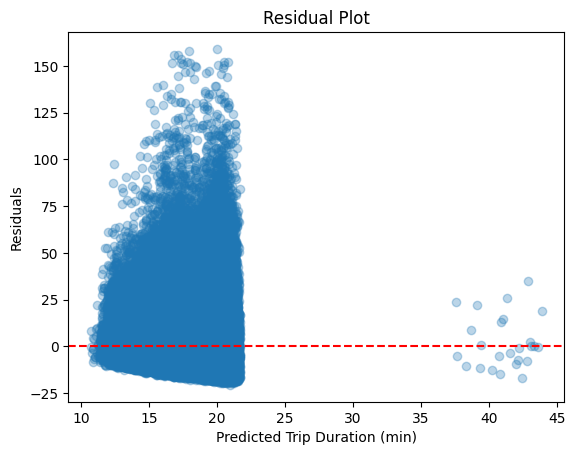

In [21]:
# Residual Plot to examine model assumptions
# Ensure y_test and y_pred have the same length
if len(y_test) != len(y_pred):
	y_test = y_test.iloc[:len(y_pred)]

# Residual Plot to examine model assumptions
plt.figure()
plt.scatter(y_pred, y_test - y_pred, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Trip Duration (min)')
plt.ylabel('Residuals')
plt.show()

# **Extended Regression Analysis: Interaction Terms and ANOVA**

This block creates interaction terms between departure period and borough dummy variables, fits a new OLS model with them, and uses ANOVA to test whether the addition of these interactions is statistically meaningful.

In [22]:
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm

# Use the training data (X_train, y_train) from our initial regression.
# Create a copy of X_train to add interaction terms.
X_train_int = X_train.copy()

# Identify departure period and borough columns (assuming they start with these prefixes).
dep_period_cols = [col for col in X_train_int.columns if col.startswith('departure_period_')]
borough_cols = [col for col in X_train_int.columns if col.startswith('Borough_')]

# Create interaction terms between each departure period dummy and each borough dummy.
for dp in dep_period_cols:
    for bc in borough_cols:
         new_col = f"{dp}_X_{bc}"
         X_train_int[new_col] = X_train_int[dp].astype(float) * X_train_int[bc].astype(float)

# Remove rows with NaN or infinite values from X_train and y_train
X_train_clean = X_train.replace([np.inf, -np.inf], np.nan).dropna()
y_train_clean = y_train[X_train_clean.index]

# Base model without interaction terms.
X_train_sm_base = sm.add_constant(X_train_clean)
model_base = sm.OLS(y_train_clean.astype(float), X_train_sm_base.astype(float)).fit()

# Remove rows with NaN or infinite values from X_train_int
X_train_int_clean = X_train_int.replace([np.inf, -np.inf], np.nan).dropna()
y_train_int_clean = y_train[X_train_int_clean.index]

# Extended model with interaction terms.
X_train_sm_int = sm.add_constant(X_train_int_clean)
model_int = sm.OLS(y_train_int_clean.astype(float), X_train_sm_int.astype(float)).fit()

# Display summaries.
print("=== Base Model Summary ===")
print(model_base.summary())
print("\n=== Extended Model with Interaction Terms Summary ===")
print(model_int.summary())

# Perform ANOVA to test the significance of adding interaction terms.
anova_results = anova_lm(model_base, model_int)
print("\n=== ANOVA Comparison Between Base and Interaction Model ===")
print(anova_results)


=== Base Model Summary ===
                            OLS Regression Results                            
Dep. Variable:      trip_duration_min   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     3607.
Date:                Sun, 13 Apr 2025   Prob (F-statistic):               0.00
Time:                        03:07:41   Log-Likelihood:            -1.3010e+07
No. Observations:             3369144   AIC:                         2.602e+07
Df Residuals:                 3369119   BIC:                         2.602e+07
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------